In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models # type: ignore
import matplotlib.pyplot as plt
import os
import librosa

In [2]:
def extract_spectrogram(file_path, max_pad_len=174):
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    audio_tensor = tf.convert_to_tensor(audio, dtype=tf.float32)
    spectrogram = tf.signal.stft(audio_tensor, frame_length=1024, frame_step=512, fft_length=1024)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=-1)
    spectrogram = tf.image.resize(spectrogram, [13, max_pad_len])
    return spectrogram

In [3]:
def load_data_spectrogram(dataset_path):
    spectrogram_list = []
    labels = []
    
    for fold in os.listdir(dataset_path):
        fold_path = os.path.join(dataset_path, fold)
        if os.path.isdir(fold_path):
            for file_name in os.listdir(fold_path):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(fold_path, file_name)
                    spectrogram = extract_spectrogram(file_path)
                    label = int(file_name.split('-')[1])
                    spectrogram_list.append(spectrogram)
                    labels.append(label)
    
    return np.array(spectrogram_list), np.array(labels)

In [4]:
dataset_path = 'UrbanSound8K'
spectrograms, labels = load_data_spectrogram(dataset_path)
X_spec_train, X_spec_test, y_train, y_test = train_test_split(
    spectrograms, labels, test_size=0.2, random_state=42)

In [5]:
input_shape_spec = X_spec_train[0].shape
model_spec = models.Sequential([
    layers.Input(shape=input_shape_spec),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

In [6]:
model_spec.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [7]:
history_spec = model_spec.fit(X_spec_train, y_train, epochs=10, validation_data=(X_spec_test, y_test))

Epoch 1/10
219/219 [==============================] - 7s 29ms/step - loss: 1.6650 - accuracy: 0.4233 - val_loss: 1.2647 - val_accuracy: 0.5604
Epoch 2/10
219/219 [==============================] - 6s 28ms/step - loss: 1.2405 - accuracy: 0.5847 - val_loss: 1.0513 - val_accuracy: 0.6640
Epoch 3/10
219/219 [==============================] - 6s 29ms/step - loss: 1.0477 - accuracy: 0.6464 - val_loss: 0.9491 - val_accuracy: 0.7035
Epoch 4/10
219/219 [==============================] - 6s 29ms/step - loss: 0.9207 - accuracy: 0.6935 - val_loss: 0.8737 - val_accuracy: 0.7287
Epoch 5/10
219/219 [==============================] - 6s 29ms/step - loss: 0.8258 - accuracy: 0.7248 - val_loss: 0.8309 - val_accuracy: 0.7390
Epoch 6/10
219/219 [==============================] - 6s 28ms/step - loss: 0.7388 - accuracy: 0.7522 - val_loss: 0.7969 - val_accuracy: 0.7642
Epoch 7/10
219/219 [==============================] - 6s 28ms/step - loss: 0.6665 - accuracy: 0.7767 - val_loss: 0.7426 - val_accuracy: 0.7779

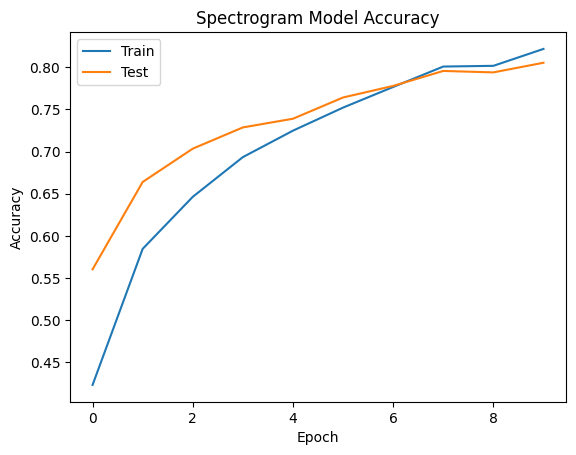

In [8]:
plt.plot(history_spec.history['accuracy'])
plt.plot(history_spec.history['val_accuracy'])
plt.title('Spectrogram Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()